In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
import pandas as pd
import numpy as np
from functools import partial
import yaml
%config Completer.use_jedi = False

In [5]:
test_sim = SuperSimulationFactory.build_super_simulation('../state/VA/SB91/VA_sb91_model_inputs.yaml')
test_sim.initializer.data_dict['total_population_data'] = test_sim.initializer.data_dict['total_population_data'][test_sim.initializer.data_dict['total_population_data'].compartment == 'prison']
# commented this out once I'm working on the policy but this should be the first thing you run to make sure the simulation is functional
# test_sim.simulate_baseline(['prison', 'prison_parole_rev_tech', 'prison_parole_rev_new', 'parole', 'parole_two', 'parole_three'])

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1767: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


outflows_data returned 55 results
transitions_data returned 24 results
total_population_data returned 142 results


initialization time:  29.473490238189697
initialization time:  32.89984488487244
simulation_time:  35.712637186050415
simulation_time:  21.141663789749146


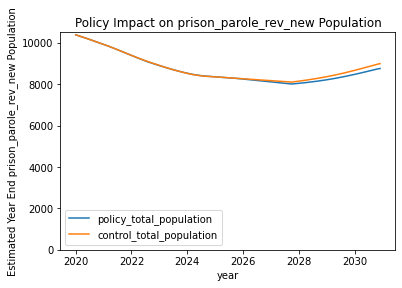

In [7]:
pd.set_option('display.max_rows', 500)
AFFECTED = 0.05

compartments_dict = {
    'prison': {'reduction_size': 0.25, 'outflow': 'parole'},
    'prison_parole_rev_new': {'reduction_size': 0.33, 'outflow': 'parole_two'},
    'prison_parole_rev_new_two': {'reduction_size': 0.5, 'outflow': 'parole_three'},
    'prison_parole_rev_new_three': {'reduction_size': 0.75, 'outflow': 'parole_three'},

}

# Policy Option Methods



def implement_parole(compartment, retroactive=False):
    return partial(TransitionTable.apply_reduction, 
                   reduction_df=pd.DataFrame({
                       'outflow': [compartments_dict[compartment]['outflow']],
                       'affected_fraction': [AFFECTED],
                       'reduction_size': [(85-compartments_dict[compartment]['reduction_size'])/85]
                   }),
                   reduction_type='*',
                   retroactive=retroactive
)

policy_list_non_retroactive = [
    SparkPolicy(policy_fn=implement_parole(compartment),
                spark_compartment=compartment,
                sub_population={'crime_type': 'x'},
                policy_ts=12)
    for compartment in compartments_dict
]
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive, 'prison_parole_rev_new')

In [18]:
simulation_tag = 'VA_SB91_5%'
test_sim.upload_policy_simulation_results_to_bq(simulation_tag)

{'spending_diff':                        prison prison_parole_rev_tech prison_parole_rev_new  \
 year                                                                         
 2020.000000               0.0                    0.0                   0.0   
 2020.083333               0.0                    0.0                   0.0   
 2020.166667               0.0                    0.0                   0.0   
 2020.250000               0.0                    0.0                   0.0   
 2020.333333               0.0                    0.0                   0.0   
 2020.416667               0.0                    0.0                   0.0   
 2020.500000               0.0                    0.0                   0.0   
 2020.583333               0.0                    0.0                   0.0   
 2020.666667               0.0                    0.0                   0.0   
 2020.750000               0.0                    0.0                   0.0   
 2020.833333               0.0     